# Setting

Mount your Google Drive

In [1]:
import os
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Set up mount symlink

In [2]:
DRIVE_PATH = '/content/gdrive/My\ Drive/PointNet'
DRIVE_PYTHON_PATH = DRIVE_PATH.replace('\\', '')
if not os.path.exists(DRIVE_PYTHON_PATH):
  %mkdir $DRIVE_PATH

## the space in `My Drive` causes some issues,
## make a symlink to avoid this
SYM_PATH = '/content/PointNet'
if not os.path.exists(SYM_PATH):
  !ln -s $DRIVE_PATH $SYM_PATH

## Import and others

In [43]:
from pathlib import Path

import numpy as np
import torch
import torch.nn.functional as F
import  matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms


import time

In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda:0


## Download data
Original dataset takes too much time in reading files and sampling - so we did it beforehand.

It reduced training time from 40 mins per epoch to 1 mins per epoch!

In [13]:
%cd $SYM_PATH

# This may take a few minutes
if not os.path.exists("PointCloudAlchemist"):
    !git clone https://github.com/Joohwan-Seo/CS282A_final_project.git PointCloudAlchemist
else:
    print("Already downloaded.")

%cd PointCloudAlchemist

/content/gdrive/My Drive/PointNet
Cloning into 'PointCloudAlchemist'...
remote: Enumerating objects: 70, done.
remote: Counting objects: 100% (47/47), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 70 (delta 23), reused 30 (delta 13), pack-reused 23
Unpacking objects: 100% (70/70), 232.13 MiB | 7.06 MiB/s, done.
Updating files: 100% (22/22), done.
/content/gdrive/My Drive/PointNet/PointCloudAlchemist


In [14]:
!pwd

/content/gdrive/My Drive/PointNet/PointCloudAlchemist


In [15]:
from utils import PointCloudData, Normalize, RotateXYZ, AddGaussianNoise, read_off, view_mesh, view_scatter
from network_sol import PointNetClassification, PointNetSegmentation, GetModel, PointNetLoss
from train_sol import TrainModel

## visualize image

The orignal dataset has objects given in a mesh form. Here is a visualisation of a chair in the original dataset.

In [17]:
verts, faces = read_off("data_for_viz/chair_0003.off")

In [18]:
i,j,k = np.array(faces).T
x,y,z = np.array(verts).T

In [ ]:
view_mesh(x,y,z, i,j,k )

Now we turn the mesh objects into a point cloud using three different sampling methods. We can sample points randomly from the mesh faces, here is what that point cloud looks like.

In [ ]:
default = np.load("data_for_viz/chair_default.pkl", allow_pickle=True)
view_scatter(*default)

Here is the result of the original sampling method as proposed by the paper, where points are sampled from the faces of the objects.

In [ ]:
original = np.load("data_for_viz/chair_original.pkl", allow_pickle=True)
view_scatter(*original)

Here is the point cloud from sampling based on the farthest point, where we find the centroid of the mesh surface and sample the farthest point from it, we iterate this to get the following point cloud.

In [ ]:
farthest = np.load("data_for_viz/chair_farthest.pkl", allow_pickle=True)
view_scatter(*farthest)

### Implement transforms function 
We first define the data transforms, which is called by `torch.DataLoader`.
The transforms normalize, rotate and add noise to the pointclouds.

In [29]:
pointnet_tf = transforms.Compose([Normalize(),
                                  RotateXYZ(),
                                  AddGaussianNoise(),
                                  transforms.ToTensor()
                                ])

In [30]:
torch.manual_seed(340420)

method = 'random'

all_data = {'train': PointCloudData(data_split = "train", method = method, acc_type = 'valid' , transform = pointnet_tf),
            'test' : PointCloudData(data_split = "test",  method = method, acc_type = 'valid' , transform = pointnet_tf)
            } 

all_dataloader = {'train': DataLoader(dataset = all_data['train'], batch_size = 32, shuffle = True),
                  'test' : DataLoader(dataset = all_data['test'] , batch_size = 64)
                 }

The details of the dataset can be found in the following block.

In [31]:
num_to_class = {i: cat for cat, i in all_data['train'].classes.items()}

for t in ['train', 'test']:
    print(f"# of {t} data = {len(all_data[t])}")

print(f"# of classes: {len(all_data['train'].classes)}")

any_idx = 3990
assert any_idx < len(all_data['train'])

print(f"Sampled pointcloud shape: {all_data['train'][any_idx]['pointcloud'].size()}")
print(f"Class of the {any_idx}-th train data = {num_to_class[all_data['train'][any_idx]['category']]}")

# of train data = 3991
# of test data = 908
# of classes: 10
Sampled pointcloud shape: torch.Size([1024, 3])
Class of the 3990-th train data = toilet


# Write down core functions
Finish `network.py` and `train.py` - there are detailed comments in the code.


# Model Training & Testing
Now, we will test the training results under several conditions. 
In particular, the questions we want to answer is as follows:
- What is the role of the Tnet?
- How does the data sampling method affect the performance?

To answer this question, we will train 4 classification models: with/without Tnet, random/farthest sampling method.

For the segmentation tasks, we fix the sampling method as random, but we are only checking with with/without Tnet.



In [36]:
# If you rerun this cell, you will lost all your work
model_dict, output_dict = {}, {}
for tnet in ['yes_t', 'no_t']:
    model_dict[tnet], output_dict[tnet] = {}, {}
    for task in ['Classification', 'Segmentation']:
        model_dict[tnet][task], output_dict[tnet][task] = {}, {}
        for method in ['random', 'farthest']:
            model_dict[tnet][task][method], output_dict[tnet][task][method] = None, None

## Classification Model training
### Case 1: With Tnet / Random



In [ ]:
tnet = 'yes_t' 
task = 'Classification'
method = 'random'

# set model and check device
model_dict[tnet][task][method], optimizer, scheduler = GetModel(tnet, task, DEVICE)
print(next(model_dict[tnet][task][method].parameters()).device)

# train
output_dict[tnet][task][method] = TrainModel(
    task         = task,
    model        = model_dict[tnet][task][method],
    train_loader = all_dataloader['train'], # training
    valid_loader = all_dataloader['test'],  # validation (and test)
    num_epochs   = 30,
    optimizer    = optimizer,
    scheduler    = scheduler,
    device       = DEVICE,
    save         = False
)

### Case 2: Without Tnet / Random

In [ ]:
tnet = 'no_t' 
task = 'Classification'
method = 'random'

# set model and check device
model_dict[tnet][task][method], optimizer, scheduler = GetModel(tnet, task, DEVICE)
print(next(model_dict[tnet][task][method].parameters()).device)

# train
output_dict[tnet][task][method] = TrainModel(
    task         = task,
    model        = model_dict[tnet][task][method],
    train_loader = all_dataloader['train'], # training
    valid_loader = all_dataloader['test'],  # validation (and test)
    num_epochs   = 30,
    optimizer    = optimizer,
    scheduler    = scheduler,
    device       = DEVICE,
    save         = False
)

### Re-defining Dataloaders

In [47]:
method = 'farthest'

all_data = {'train': PointCloudData(data_split = "train", method = method, acc_type = 'valid' , transform = pointnet_tf),
            'test' : PointCloudData(data_split = "test",  method = method, acc_type = 'valid' , transform = pointnet_tf)
            } 

all_dataloader = {'train': DataLoader(dataset = all_data['train'], batch_size = 32, shuffle = True),
                  'test' : DataLoader(dataset = all_data['test'] , batch_size = 64)
                 }

## Case 3: With Tnet / Farthest

In [ ]:
tnet = 'yes_t' 
task = 'Classification'
method = 'farthest'

# set model and check device
model_dict[tnet][task][method], optimizer, scheduler = GetModel(tnet, task, DEVICE)
print(next(model_dict[tnet][task][method].parameters()).device)

# train
output_dict[tnet][task][method] = TrainModel(
    task         = task,
    model        = model_dict[tnet][task][method],
    train_loader = all_dataloader['train'], # training
    valid_loader = all_dataloader['test'],  # validation (and test)
    num_epochs   = 30,
    optimizer    = optimizer,
    scheduler    = scheduler,
    device       = DEVICE,
    save         = False
)

## Case 4: Without Tnet / Farthest

In [ ]:
tnet = 'no_t' 
task = 'Classification'
method = 'farthest'

# set model and check device
model_dict[tnet][task][method], optimizer, scheduler = GetModel(tnet, task, DEVICE)
print(next(model_dict[tnet][task][method].parameters()).device)

# train
output_dict[tnet][task][method] = TrainModel(
    task         = task,
    model        = model_dict[tnet][task][method],
    train_loader = all_dataloader['train'], # training
    valid_loader = all_dataloader['test'],  # validation (and test)
    num_epochs   = 30,
    optimizer    = optimizer,
    scheduler    = scheduler,
    device       = DEVICE,
    save         = False
)

## Part segmentation models training


Re-defining dataloader for the Segmentation tasks

In [62]:
all_data = {'train': PointCloudData(data_split = "train", method = 'random', task = 'Segmentation', acc_type = 'valid' , transform = pointnet_tf),
            'test' : PointCloudData(data_split = "test",  method = 'random', task = 'Segmentation', acc_type = 'valid' , transform = pointnet_tf)
            } 
all_dataloader = {'train': DataLoader(dataset = all_data['train'], batch_size = 32, shuffle = True),
                  'test' : DataLoader(dataset = all_data['test'] , batch_size = 64)
                 }

## Case 1: With Tnet / Random

In [ ]:
tnet = 'yes_t' 
task = 'Segmentation'
method = 'random'

# set model and check device
model_dict[tnet][task][method], optimizer, scheduler = GetModel(tnet, task, DEVICE)
print(next(model_dict[tnet][task][method].parameters()).device)

# train
output_dict[tnet][task][method] = TrainModel(
    task         = task,
    model        = model_dict[tnet][task][method],
    train_loader = all_dataloader['train'], # training
    valid_loader = all_dataloader['test'],  # validation (and test)
    num_epochs   = 30,
    optimizer    = optimizer,
    scheduler    = scheduler,
    device       = DEVICE,
    save         = False
)

## Case 2: With Tnet / Random

In [ ]:
tnet = 'no_t' 
task = 'Segmentation'
method = 'random'

# set model and check device
model_dict[tnet][task][method], optimizer, scheduler = GetModel(tnet, task, DEVICE)
print(next(model_dict[tnet][task][method].parameters()).device)

# train
output_dict[tnet][task][method] = TrainModel(
    task         = task,
    model        = model_dict[tnet][task][method],
    train_loader = all_dataloader['train'], # training
    valid_loader = all_dataloader['test'],  # validation (and test)
    num_epochs   = 30,
    optimizer    = optimizer,
    scheduler    = scheduler,
    device       = DEVICE,
    save         = False
)

# Plotting for the training loss and validation accuracy
## Classification

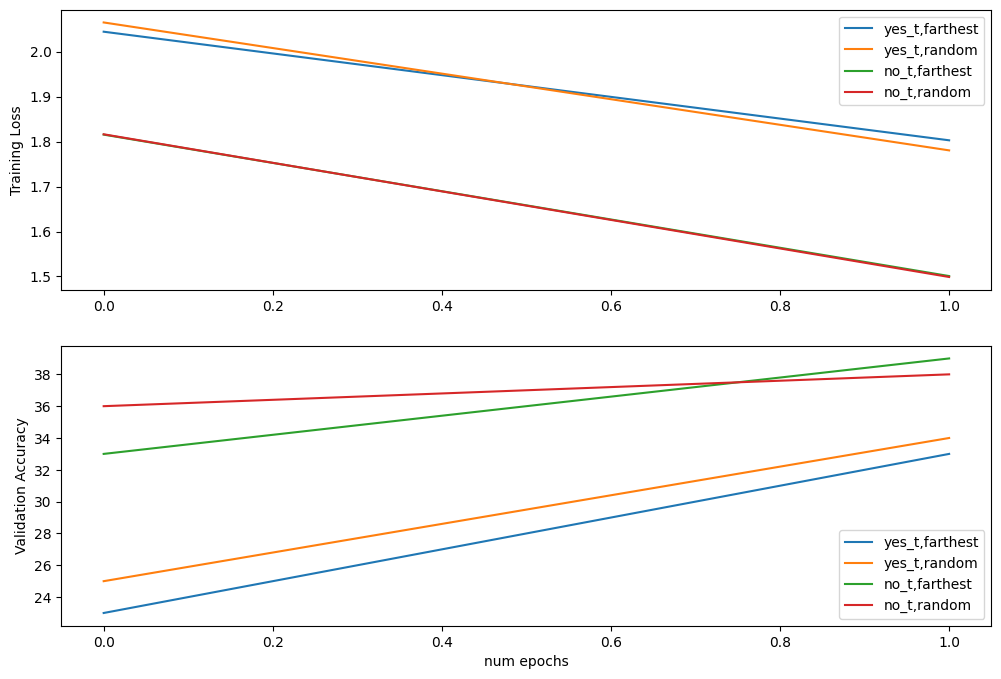

In [60]:
arg_tnet = ['yes_t', 'no_t']
arg_method = ['farthest', 'random']

# For the classification task
task = 'Classification'
k = 1
plt.figure(1, figsize = (12,8))
legend = []
for tnet in arg_tnet:
  for method in arg_method:
    plt.subplot(2,1,1)
    data = output_dict[tnet][task][method]
    train_loss = []
    acc = []
    N = len(data)
    for i in range(N):
      train_loss.append(np.mean(data[i]['train_loss']))
      acc.append(data[i]['accuracy'])

    plt.subplot(2,1,1)
    plt.plot(range(N), train_loss)
    plt.subplot(2,1,2)
    plt.plot(range(N), acc)
    legend.append(tnet + ',' + method)

plt.subplot(2,1,1)
plt.legend(legend);
plt.ylabel('Training Loss');
plt.subplot(2,1,2)
plt.legend(legend);
plt.ylabel('Validation Accuracy');
plt.xlabel('num epochs');

    # break

## Segmentation

In [ ]:
arg_tnet = ['yes_t', 'no_t']
arg_method = ['random']

# For the classification task
task = 'Segmentation'
k = 1
plt.figure(1, figsize = (12,8))
legend = []
for tnet in arg_tnet:
  for method in arg_method:
    plt.subplot(2,1,1)
    data = output_dict[tnet][task][method]
    train_loss = []
    acc = []
    N = len(data)
    for i in range(N):
      train_loss.append(np.mean(data[i]['train_loss']))
      acc.append(data[i]['accuracy'])

    plt.subplot(2,1,1)
    plt.plot(range(N), train_loss)
    plt.subplot(2,1,2)
    plt.plot(range(N), acc)
    legend.append(tnet + ',' + method)

plt.subplot(2,1,1)
plt.legend(legend);
plt.ylabel('Training Loss');
plt.subplot(2,1,2)
plt.legend(legend);
plt.ylabel('Validation Accuracy');
plt.xlabel('num epochs');

# Test accuracy

In [77]:
tnet = 'yes_t' 
task = 'Segmentation'
method = 'random'

mymodel = model_dict[tnet][task][method]
mymodel.eval();

In [79]:
test_data = PointCloudData(data_split = "test",  method = method, task = task, acc_type = 'test' , transform = None)
test_loader = DataLoader(dataset = test_data , batch_size = 64)

with torch.no_grad():
  correct, total = 0, 0
  for data in test_loader:
      # get pointcloud and category
      pointcloud = data['pointcloud'].to(DEVICE).float()
      category   = data['category'].to(DEVICE)
      # run the model
      output, _, _ = mymodel(pointcloud.transpose(1,2))
      _, predict_category = torch.max(output.data, 1)
      # record the correct predicitons
      if task == "Classification":
        total += predict_category.size(0)
      elif task == "Segmentation":
        total += predict_category.size(0) * predict_category.size(1)  
      correct += (predict_category == category).sum().item()

accuracy = int((correct / total) * 100)
print(f"Test accuracy: {accuracy}")

Test accuracy: 26
